In [1]:
%pylab inline

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
from sympy import sympify
import sys; sys.path.insert(0, "../"); from utils import *
from models import SympyTorch, PartialDerivativeCalculator, CoeffLearner
from parametric_discovery_pinn import ParametricPINN, BurgerPINN, FinalParametricPINN, RobustPCANN
from pytorch_robust_pca import *
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR
from parametric_pde_diff import TrainSGTRidge, create_groups

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib
Running Python 3.9.8
You can use npar for np.array


In [2]:
data = pickle_load("../parametric_pde_data/parametric_burgers.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
X, T = np.meshgrid(x, t)

# Adding noise
noise_intensity = 0.01
NOISELESS_MODE = False
if NOISELESS_MODE: print("Denoising off")
else: print("Denoising on")
noisy_xt = False; noisy_labels = False; mode = int(noisy_xt)+int(noisy_labels)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 25000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# Add noise to (x, t) before setting the lb, and ub.
if noisy_xt: 
    print("Noisy (x, t)")
    X_train_clean = X_train
    X_train = perturb(X_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean (x, t)")
if noisy_labels:
    print("Noisy labels")
    u_train_clean = u_train
    u_train = perturb(u_train, intensity=noise_intensity, noise_type="normal")
else: print("Clean labels")

# converting to tensor
X_star = to_tensor(X_star, True)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

u_xx_true = 0.1*np.ones(time_dims)
uu_x_true = -1*(1+0.25*np.sin(t))

feature_names = ['u', 'u_x', 'u_xx']

# del X_star, u_star, X, T, Exact, data

Loaded from ../parametric_pde_data/parametric_burgers.pkl
Denoising on
Clean (x, t)
Clean labels


In [3]:
# 1st stage results
# Clean all: −0.2202415sin(t)−1.0147734
# Noisy1: −0.21593435sin(t)−1.0181545
# Noisy2 (-1.0178235 + (-0.21506631 * sin(t))) | "-0.1872898*sin(t)-1.0238724"

In [4]:
pinn = ParametricPINN(scale=False, lb=lb, ub=ub)
print("Loaded the pretrained weights")
pinn.load_state_dict(torch.load("./saved_path_inverse_parametric_burgers/parametric_pinn.pth"))
model = nn.Sequential(pinn.preprocessor_net, pinn.pde_solver_net)

if mode == 0 or mode > 2: func_terms = ["-0.2202415*sin(t)-1.0147734", "0.09875935"]
elif mode == 1: func_terms = ["-0.21593435*sin(t)-1.0181545", "0.09875935"]
elif mode == 2: func_terms = ["-0.1872898*sin(t)-1.0238724", "0.09875935"]

pde_terms = ["u*u_x", "u_xx"]
final_burger_pinn = FinalParametricPINN(model=model, pde_terms=pde_terms, func_terms=func_terms, uncert=True, scale=pinn.scale, lb=pinn.lb, ub=pinn.ub)
del pinn

Loaded the pretrained weights


In [5]:
_, x_fft, x_PSD = fft1d_denoise(X_train[:, 0:1], c=-5, return_real=True)
_, t_fft, t_PSD = fft1d_denoise(X_train[:, 1:2], c=-5, return_real=True)
_, u_train_fft, u_train_PSD = fft1d_denoise(u_train, c=-5, return_real=True)
x_fft, x_PSD = x_fft.detach(), x_PSD.detach()
t_fft, t_PSD = t_fft.detach(), t_PSD.detach()

In [6]:
### New implementation ###
class RobustFinalParametricPINN(nn.Module):
    def __init__(self, pinn, init_cs=(0.1, 0.1), init_betas=(0.0, 0.0), noiseless_mode=True):
        super(RobustFinalParametricPINN, self).__init__()
        self.pinn = pinn
        self.noiseless_mode = noiseless_mode
        self.in_fft_nn = None; self.out_fft_nn = None
        self.inp_rpca = None; self.out_rpca = None
        if not self.noiseless_mode:
            # FFTNN
            self.in_fft_nn = FFTTh(c=init_cs[0])
            self.out_fft_nn = FFTTh(c=init_cs[1])

            # Robust Beta-PCA
            self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
            self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=1, hidden_dims=32)

    def forward(self, x, t):
        return self.pinn(x, t)

    def loss(self, X_input, X_input_noise, y_input, y_input_noise):
        if not self.noiseless_mode:
            # (1) Denoising FFT on (x, t)
            # This line returns the approx. recon.
            X_input_noise = cat(torch.fft.ifft(self.in_fft_nn(X_input_noise[1])*X_input_noise[0]).real.reshape(-1, 1), 
                                torch.fft.ifft(self.in_fft_nn(X_input_noise[3])*X_input_noise[2]).real.reshape(-1, 1))
            X_input_noise = X_input-X_input_noise
            X_input = self.inp_rpca(X_input, X_input_noise, normalize=True)
            
            # (2) Denoising FFT on y_input
            y_input_noise = y_input-torch.fft.ifft(self.out_fft_nn(y_input_noise[1])*y_input_noise[0]).real.reshape(-1, 1)
            y_input = self.out_rpca(y_input, y_input_noise, normalize=True)
            
        return self.pinn.loss(X_input[:, 0:1], X_input[:, 1:2], y_input)

In [7]:
robust_buger_pinn = RobustFinalParametricPINN(pinn=final_burger_pinn, noiseless_mode=NOISELESS_MODE)

In [8]:
def pcgrad_closure(return_list=False):
    global N, X_train, X_train_L, X_train_S, u_train
    losses = robust_buger_pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD))
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in robust_buger_pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(robust_buger_pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [9]:
def finetuning_closure():
    global N, X_train, X_train_L, X_train_S, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = robust_buger_pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD))
    loss = mse_loss + pde_loss
    if loss.requires_grad: loss.backward(retain_graph=True)
    return loss

In [10]:
if mode == 0: robust_buger_pinn = load_weights(robust_buger_pinn, "./saved_path_inverse_parametric_burgers/final_parametric_pinn.pth")
elif mode == 1: robust_buger_pinn = load_weights(robust_buger_pinn, "./saved_path_inverse_parametric_burgers/noisy_final_doublerpca_parametric_pinn(new).pth")
elif mode == 2: robust_buger_pinn = load_weights(robust_buger_pinn, "./saved_path_inverse_parametric_burgers/noisy2_final_doublerpca_parametric_pinn.pth")

Loaded the model's weights properly


In [11]:
# epochs = 50 # 50 for clean all, 10 for noisy1, 50 for noisy2
# f_opt = torch.optim.LBFGS(robust_buger_pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(1.25*500), history_size=300, line_search_fn='strong_wolfe')
# final_burger_pinn.is_uncert = False
# for i in range(epochs): # 50 for clean all, 10 for noisy1, 50 for noisy2
#     f_opt.step(finetuning_closure)
#     if i%10==0: print(finetuning_closure())

In [12]:
u_pred = robust_buger_pinn(X_star[:, 0:1], X_star[:, 1:2]).detach().numpy()
rel = relative_l2_error(u_pred, u_star)
rel

0.004565993856538862

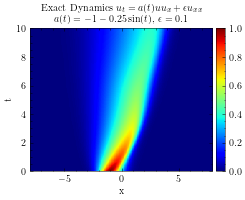

In [13]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(Exact.T, interpolation='nearest', cmap='jet', 
          extent=[lb[0], ub[0], lb[1], ub[1]], 
          origin='lower', aspect='auto')

ax.set_title("Exact Dynamics $u_{t} = a(t)uu_{x}+\epsilon u_{xx}$\n $a(t)=-1-0.25\sin(t)$, $\epsilon = 0.1$", fontsize = 10)
ax.set_xlabel('x')
ax.set_ylabel('t')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# fig.savefig("./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

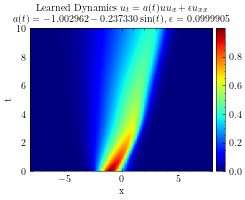

In [14]:
fig, ax = plt.subplots(1, 1)

h = ax.imshow(u_pred.reshape(X.T.shape), interpolation='nearest', cmap='jet', 
          extent=[lb[0], ub[0], lb[1], ub[1]], 
          origin='lower', aspect='auto')

# [-1.00296175, -0.23732963,  0.09999029]
# [-1.00088429, -0.24525967,  0.10000382]
# [-1.00312865, -0.24390902,  0.09959546]

ax.set_title("Learned Dynamics $u_{t} = a(t)uu_{x}+\epsilon u_{xx}$\n $a(t)=-1.002962-0.237330\sin(t)$, $\epsilon = 0.0999905$", fontsize = 10)
# ax.set_title("Learned Dynamics $u_{t} = a(t)uu_{x}+\epsilon u_{xx}$\n $a(t)=-1.000884-0.245260\sin(t)$, $\epsilon = 0.100004$", fontsize = 10)
# ax.set_title("Learned Dynamics $u_{t} = a(t)uu_{x}+\epsilon u_{xx}$\n $a(t)=-1.003129-0.243909\sin(t)$, $\epsilon = 0.099595$", fontsize = 10)
ax.set_xlabel('x')
ax.set_ylabel('t')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Learned_Dynamics_cleanall.png", dpi=300)
plt.show()

In [15]:
# Newer results
# w/o DFT
# Clean all
# array([-0.99938607, -0.2458773 ,  0.09999527])
# (0.5717347065607725, 0.7621505091153221)
# Noisy1
# array([-1.00576413, -0.24115856,  0.0996802])
# (1.4775961637496966, 1.4596828696863098)
# Noisy2
# array([-1.00304902, -0.2355555 ,  0.09983284])
# (2.0832871397336343, 2.6130202986986424)

# w/ DFT
# Clean all | relative l2 error = 0.004565993856538862
# array([-1.00296175, -0.23732963,  0.09999029])
# (1.7913455764452635, 2.3199980760307097)
# Noisy1 | relative l2 error = 0.003108601268109189
# array([-1.00088429, -0.24525967,  0.10000382])
# (0.66279222567876, 0.8727860836843953)
# Noisy2 | relative l2 error = 0.005160425289619849
# array([-1.00312865, -0.24390902,  0.09959546])
# (1.0512669881184913, 0.980147199375116)

In [16]:
# New results

# Noisy Exact & Noisy (x, t) & X_train = X_train - self.beta2*self.proj(S) | beta1 = 0.0
# an attempt with reasonable results
# params: [-0.9991318583488464, -0.23970049619674683, 0.10075154900550842]
# errs: (1.6527215639750146, 1.7654708038535187)

# Noisy Exact & Clean (x, t) & rpca on (x, t) and rpca on Exact (double rpca)
# Exp NO. 1
# array([-1.00097609, -0.24441387,  0.10007171])
# (0.8012558023134849, 1.0134786013527548)
# (Parameter containing:
#  tensor([0.0005], requires_grad=True),
#  Parameter containing:
#  tensor([-0.0059], requires_grad=True))

# Noisy Exact & Noisy (x, t) & rpca on (x, t) and rpca on Exact (double rpca)
# Exp NO. 1
# params: [-1.0021382570266724, -0.24129116535186768, 0.09974975883960724]
# errs (1.3158669074376441, 1.5328440955479825)
# (0.0,
#  Parameter containing:
#  tensor([-0.0181], requires_grad=True),
#  Parameter containing:
#  tensor([0.0015], requires_grad=True))
# Exp NO. 2
# array([-1.00135529, -0.24140678,  0.09927386])
# (1.4329850673675555, 1.437619261928569)
# (Parameter containing:
#  tensor([0.0010], requires_grad=True),
#  Parameter containing:
#  tensor([0.0194], requires_grad=True))

In [17]:
# Clean Exact and clean (x, t) | final_parametric_pinn.pth
# params: [-1.0013394355773926, -0.2480146884918213, 0.0997583195567131]
# errs: (0.38991620143254785, 0.28918291006992664)

# Noisy Exact and clean (x, t)
# params: [-1.0029208660125732, -0.24306637048721313, 0.09983817487955093]
# errs: (1.075787842273714, 1.2016070382040953)

# Noisy Exact and Noisy (x, t)
# params: [-1.0028020143508911, -0.24078042805194855, 0.10122136771678925]
# errs: (1.729799310366311, 1.4368618683618857)

# ---

# Noisy Exact & Clean (x, t) & X_star = X_star_L+X_star_S
# params: [-1.000922441482544, -0.24657735228538513, 0.09988813102245331]
# errs: (0.5243907372156797, 0.5973244500071551)
# Noisy Exact & Noisy (x, t) & X_star = X_star_L+X_star_S
# params: [-1.0046403408050537, -0.24455536901950836, 0.1004636213183403]
# errs: (1.035169263680774, 0.8079990064924926)

In [18]:
# save(final_burger_pinn, "./saved_path_inverse_parametric_burgers/noisy_final_parametric_pinn.pth")
# save(final_burger_pinn, "./saved_path_inverse_parametric_burgers/noisy2_final_parametric_pinn.pth")